# Titanic - Machine Learning from Disaster

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='white', context='notebook', palette='muted')

import matplotlib.pyplot as plt

## Understanding the data

### Inspecting the data

First, let us check the training and test data sets.

In [12]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


The training set contains 891 samples, with a `Survived` label indicating whether the passenger has survived the shipwreck. The test set, with 418 sample, does not have this information, which needs to be learned from the training set.

The first few passengers information is shown in the following cell.

In [8]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Now, let us combine the training and test data sets to see if there is any anomaly or missing value.

In [13]:
full = train.append(test, ignore_index=True)
full.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [14]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


There are missing values for the `Age`, `Cabin`, `Embarked`, and `Fare` columns.

### Discovering correlations

#### Survival rate vs. embarking location

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

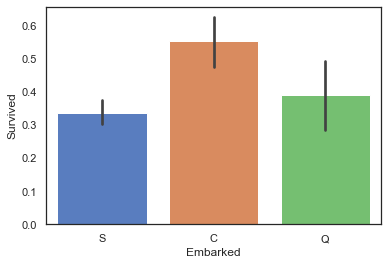

In [6]:
sns.barplot(data=train, x='Embarked', y='Survived')

In [11]:
print(full['Survived'][full['Embarked'] == 'S'].value_counts(normalize=True)[1])
print(full['Survived'][full['Embarked'] == 'C'].value_counts(normalize=True)[1])
print(full['Survived'][full['Embarked'] == 'Q'].value_counts(normalize=True)[1])

0.33695652173913043
0.5535714285714286
0.38961038961038963


From the above, we can see that passengers from Cherbourg, France are more likely to survive. It is probably due the fact that passengers from France are mainly first-class passengers. We can verify this observation.

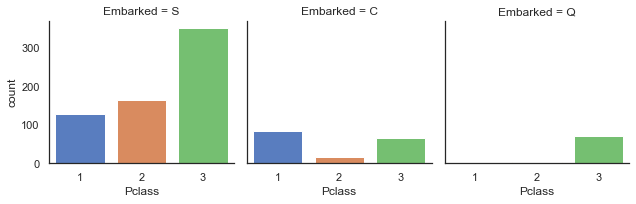

In [15]:
sns.factorplot('Pclass', col='Embarked', data=train, kind='count', size=3)

#### Survial rate vs. number of parents/children travelling together

<AxesSubplot:xlabel='Parch', ylabel='Survived'>

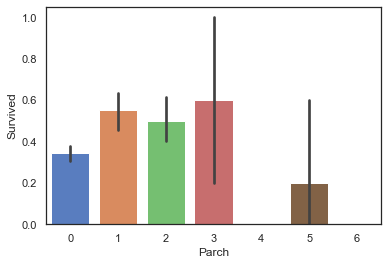

In [16]:
sns.barplot(data=train, x='Parch', y='Survived')

We can see that passengers travelling with family members between 1 and 3 are more likely to survive.

#### Survival rate vs. number of siblings travelling together

<AxesSubplot:xlabel='SibSp', ylabel='Survived'>

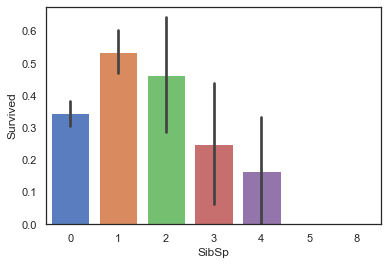

In [17]:
sns.barplot(data=train, x='SibSp', y='Survived')

#### Survival rate vs. fare class

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

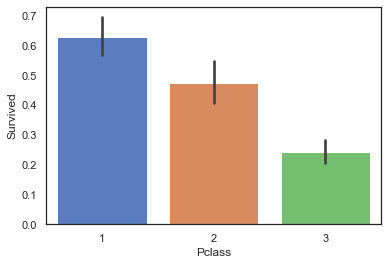

In [18]:
sns.barplot(data=train, x='Pclass', y='Survived')

Passengers with higher fare class are more likely to survive.


#### Survival rate vs. gender

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

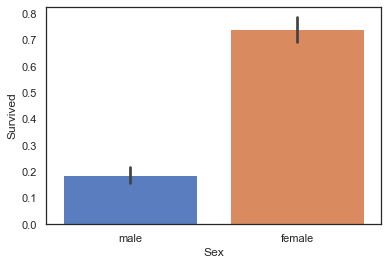

In [19]:
sns.barplot(data=train, x='Sex', y='Survived')

Female passenger are more likely to survive.

#### Survival rate vs. age

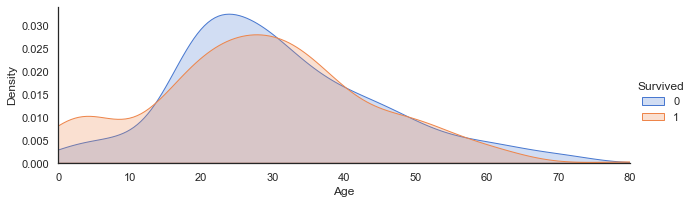

In [20]:
age = sns.FacetGrid(train, hue='Survived', aspect=3)
age.map(sns.kdeplot, 'Age', shade=True)
age.set(xlim=(0, train['Age'].max()))
age.add_legend()

Passengers with age between 0 and 10 are more likely to survive.

#### Survival rate vs. fare

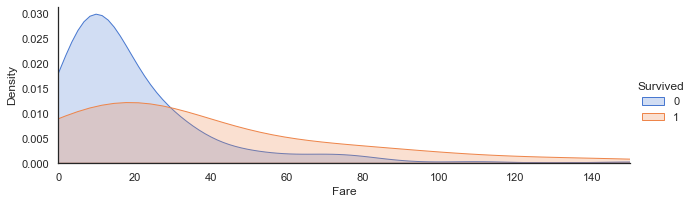

In [21]:
age = sns.FacetGrid(train, hue='Survived', aspect=3)
age.map(sns.kdeplot, 'Fare', shade=True)
age.set(xlim=(0, 150))
age.add_legend()

Passengers with higher fare are more likely to survive.

Let us check the fare distribution.

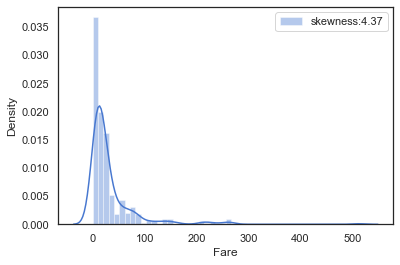

In [22]:
farePlot = sns.distplot(full['Fare'][full['Fare'].notnull()], label='skewness:%.2f'%(full['Fare'].skew()))
farePlot.legend(loc='best')

The fare distribution is highly skewed, and we need to take the logarithm of the fare.

In [23]:
full['Fare'] = full['Fare'].map(lambda x : np.log(x) if x > 0 else 0)

## Preprocessing the data

### Data cleansing

For missing data or anomalous value, we need to fill the value with some reasonable value.

#### Cabin

In [24]:
full['Cabin'] = full['Cabin'].fillna('U')
full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,U,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,U,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.085672,U,S


#### Embarked

In [25]:
full[full['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,4.382027,B28,NaN
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,4.382027,B28,NaN


They are likely to depart from Southampton.

In [26]:
full['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [27]:
full['Embarked'] = full['Embarked'].fillna('S')

#### Fare

In [32]:
full[full['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [33]:
full['Fare'] = full['Fare'].fillna(full[(full['Pclass']==3)&(full['Embarked']=='S')&(full['Cabin']=='U')]['Fare'].mean())

### Feature engineering

